1. NN, SVM  - Jiaming
2. Logistic Regression, Lasso, Ridge - Ziwei
3. Tree, Random Forest, Boosting - Tianyi

In [229]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors

import pandas as pd
import numpy as np
import os
import pickle as pkl

from datetime import datetime, timedelta
from collections import Counter
import seaborn as sns
import json


In [230]:
from sklearn import preprocessing
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [231]:
from sklearn.cross_validation import train_test_split

## Step 1. Understanding the Data

In [276]:
df = pd.read_csv('../Data/sample_5pct_2.csv', dtype={'churn': 'int64', 'uid':'int64', 'device_ip':'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21622 entries, 0 to 21621
Data columns (total 22 columns):
uid                                 21622 non-null int64
churn                               21622 non-null int64
device_ip                           21622 non-null int64
freq_last_3_days_play               21622 non-null float64
avg_daily_play_time_last_3_days     21622 non-null float64
freq_last_7_days_play               21622 non-null float64
avg_daily_play_time_last_7_days     21622 non-null float64
freq_last_14_days_play              21622 non-null float64
avg_daily_play_time_last_14_days    21622 non-null float64
freq_last_30_days_play              21622 non-null int64
avg_daily_play_time_last_30_days    21622 non-null float64
last_play                           21622 non-null int64
freq_last_30_days_search            21622 non-null float64
freq_last_14_days_search            21622 non-null float64
freq_last_7_days_search             21622 non-null float64
freq_last_3_days

In [277]:
df.set_index('uid', inplace=True)
features_num = df.columns[2:]
features_num

Index(['freq_last_3_days_play', 'avg_daily_play_time_last_3_days',
       'freq_last_7_days_play', 'avg_daily_play_time_last_7_days',
       'freq_last_14_days_play', 'avg_daily_play_time_last_14_days',
       'freq_last_30_days_play', 'avg_daily_play_time_last_30_days',
       'last_play', 'freq_last_30_days_search', 'freq_last_14_days_search',
       'freq_last_7_days_search', 'freq_last_3_days_search',
       'freq_last_3_days_download', 'freq_last_7_days_download',
       'freq_last_14_days_download', 'freq_last_30_days_download',
       'last_search', 'last_download'],
      dtype='object')

### - Important! target(y_true) must be in integer[0,1] or [-1,1]! ['0', '1'] will result in ValueError ! !
```python
classes = np.unique(y_true)
if (pos_label is None and not (np.all(classes == [0, 1]) or
 np.all(classes == [-1, 1]) or
 np.all(classes == [0]) or
 np.all(classes == [-1]) or
 np.all(classes == [1]))):
    raise ValueError("Data is not binary and pos_label is not specified")
```

In [278]:
target = df['churn']
target.value_counts()

1    11554
0    10068
Name: churn, dtype: int64

In [279]:
df.head(3)

,churn,device_ip,freq_last_3_days_play,avg_daily_play_time_last_3_days,freq_last_7_days_play,avg_daily_play_time_last_7_days,freq_last_14_days_play,avg_daily_play_time_last_14_days,freq_last_30_days_play,avg_daily_play_time_last_30_days,...,freq_last_30_days_search,freq_last_14_days_search,freq_last_7_days_search,freq_last_3_days_search,freq_last_3_days_download,freq_last_7_days_download,freq_last_14_days_download,freq_last_30_days_download,last_search,last_download
uid,,,,,,,,,,,,,,,,,,,,,
103928,0,0,0.0,0.000000,0.0,0.000000,6.0,32.071429,8,22.833333,...,35.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,90.0
748140,1,0,14.0,576.666667,14.0,247.142857,16.0,153.142857,332,1949.700000,...,46.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,22.0,22.0
1404537,0,0,14.0,952.666667,14.0,408.285714,25.0,346.428571,27,176.633333,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,90.0


***NEEDS FOLLOW-UP! EXPECT EVEN SPLIT BETWEEN 0 AND 1*** 

## Step 2. Normalize Numeric Features, One-Hot-Code Categorical Features

In [280]:
# I have done one-hot-coding in Feature Engineering notebook. 
df['device_ip'].value_counts()

0    18794
1     2828
Name: device_ip, dtype: int64

In [249]:
scaler = preprocessing.StandardScaler().fit(df[features_num])
x_scaled = scaler.transform(df[features_num])

In [282]:
# Take a Look at Variable mean and std -> rough idea of data
feature_spread = pd.DataFrame({'mean': scaler.mean_.astype(int), 'std': scaler.scale_.astype(int)}) \
                   .set_index(features_num)

In [283]:
feature_spread

,mean,std
freq_last_3_days_play,145,250
avg_daily_play_time_last_3_days,2300,3675
freq_last_7_days_play,56,125
avg_daily_play_time_last_7_days,1441,3297
freq_last_14_days_play,29,74
avg_daily_play_time_last_14_days,1217,3293
freq_last_30_days_play,15,45
avg_daily_play_time_last_30_days,1022,3244
last_play,14,11
freq_last_30_days_search,11,27


In [284]:
df_scaled = pd.DataFrame(x_scaled, columns=features_num)

In [285]:
df_scaled.head(3)

,freq_last_3_days_play,avg_daily_play_time_last_3_days,freq_last_7_days_play,avg_daily_play_time_last_7_days,freq_last_14_days_play,avg_daily_play_time_last_14_days,freq_last_30_days_play,avg_daily_play_time_last_30_days,last_play,freq_last_30_days_search,freq_last_14_days_search,freq_last_7_days_search,freq_last_3_days_search,freq_last_3_days_download,freq_last_7_days_download,freq_last_14_days_download,freq_last_30_days_download,last_search,last_download
0,-0.546643,-0.563927,-0.402246,-0.301173,-0.389785,-0.369539,-0.339170,-0.315076,-0.343305,0.845461,0.931361,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,-0.189108,-0.905035,0.820989
1,0.745590,0.510786,-0.322711,-0.220595,-0.201703,0.155699,-0.029882,0.218196,-1.097933,1.241306,-0.284530,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,0.071976,-0.586025,-1.027129
2,-0.470864,-0.145426,-0.251130,0.298157,-0.201703,0.498165,-0.029882,0.565901,-1.014085,-0.306088,-0.284530,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,-0.189108,-0.399937,0.820989


In [286]:
# because df has been indexed, df_scaled also need to be indexed to enable any joining !! 
# Be carefule !! column value assignment is implicit joining !!
df_scaled['uid'] = df.index
df_scaled.set_index('uid', inplace=True)


df_scaled['device_ip'] = df['device_ip']
df_scaled['churn'] = target

In [287]:
df_scaled.head(4)

,freq_last_3_days_play,avg_daily_play_time_last_3_days,freq_last_7_days_play,avg_daily_play_time_last_7_days,freq_last_14_days_play,avg_daily_play_time_last_14_days,freq_last_30_days_play,avg_daily_play_time_last_30_days,last_play,freq_last_30_days_search,...,freq_last_7_days_search,freq_last_3_days_search,freq_last_3_days_download,freq_last_7_days_download,freq_last_14_days_download,freq_last_30_days_download,last_search,last_download,device_ip,churn
uid,,,,,,,,,,,,,,,,,,,,,
103928,-0.546643,-0.563927,-0.402246,-0.301173,-0.389785,-0.369539,-0.339170,-0.315076,-0.343305,0.845461,...,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,-0.189108,-0.905035,0.820989,0,0
748140,0.745590,0.510786,-0.322711,-0.220595,-0.201703,0.155699,-0.029882,0.218196,-1.097933,1.241306,...,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,0.071976,-0.586025,-1.027129,0,1
1404537,-0.470864,-0.145426,-0.251130,0.298157,-0.201703,0.498165,-0.029882,0.565901,-1.014085,-0.306088,...,-0.207369,-0.209055,-0.077396,-0.0993,-0.137909,-0.189108,-0.399937,0.820989,0,0
1809207,1.232172,0.423443,-0.044339,-0.023952,-0.255441,-0.193447,-0.317078,-0.242329,-1.014085,0.701518,...,-0.207369,-0.209055,-0.077396,-0.0993,-0.079124,-0.128858,-0.798698,-1.244555,0,0


In [288]:
final_features = df_scaled.columns[:-1]
len(final_features)

20

## Step 2. Fit Logistic Regression

In [299]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled[final_features], df_scaled['churn'], \
                                                    test_size=0.2, random_state=49)

In [300]:
print('Entire sample churn split:')
print(df_scaled['churn'].value_counts())
print('Training data churn split:')
print(y_train.value_counts())
print('\n Testing data churn split:')
print(y_test.value_counts())

Entire sample churn split:
1    11554
0    10068
Name: churn, dtype: int64
Training data churn split:
1    9279
0    8018
Name: churn, dtype: int64

 Testing data churn split:
1    2275
0    2050
Name: churn, dtype: int64


In [301]:
np.unique(y_train)
# integer is required for Logistic Regression !! 

array([0, 1])

In [310]:
def fit_and_roc(x_train, y_train, x_test, y_test):
    # fit model
    model_LR = LogisticRegression()
    model_LR.fit(x_train, y_train)
    
    # evaluate training error
    y_train_pred = model_LR.predict(x_train)
    y_train_prob = model_LR.predict_proba(x_train)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # evaluate testing error
    y_test_pred = model_LR.predict(x_test)
    y_test_prob = model_LR.predict_proba(x_test)[:, 1]
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_prob, pos_label=1)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # plot roc
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, \
             color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
    plt.plot(fpr_test, tpr_test, \
             color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    return model_LR.coef_

- **Plot ROC Curve **

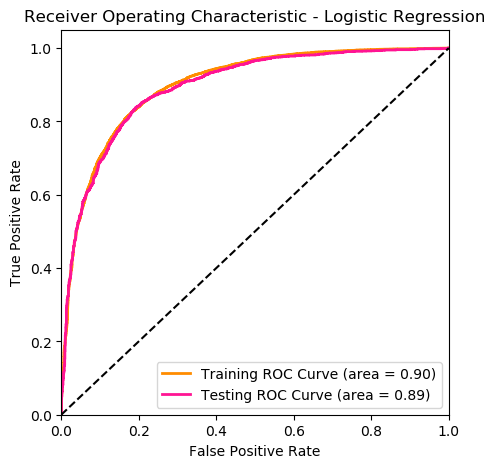

In [311]:

lr_coef = fit_and_roc(x_train, y_train, x_test, y_test)

- **Which features are important ?**

In [304]:
df_coef = pd.DataFrame(list(zip(final_features, lr_coef.flatten())), columns={'features', 'coefficient'}) \
            .sort_values(by=['coefficient'], ascending=False)
    
df_coef

,features,coefficient
8,last_play,1.482095
17,last_search,0.226100
18,last_download,0.181268
5,avg_daily_play_time_last_14_days,0.120617
13,freq_last_3_days_download,0.070333
15,freq_last_14_days_download,0.055896
10,freq_last_14_days_search,0.044045
1,avg_daily_play_time_last_3_days,0.020889
16,freq_last_30_days_download,0.010979
0,freq_last_3_days_play,0.009951


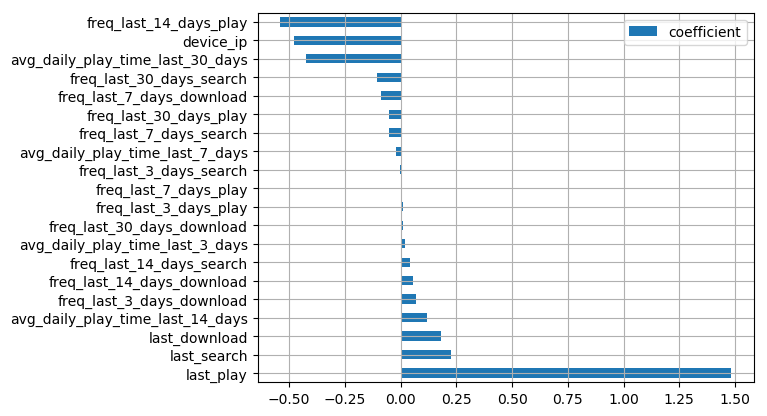

In [312]:
plt.figure(figsize=(90, 50))
ax = df_coef.plot.barh()

plt.grid(True)
ax.set_yticks(np.arange(df_coef.shape[0]))
ax.set_yticklabels(df_coef['features'])
plt.show()

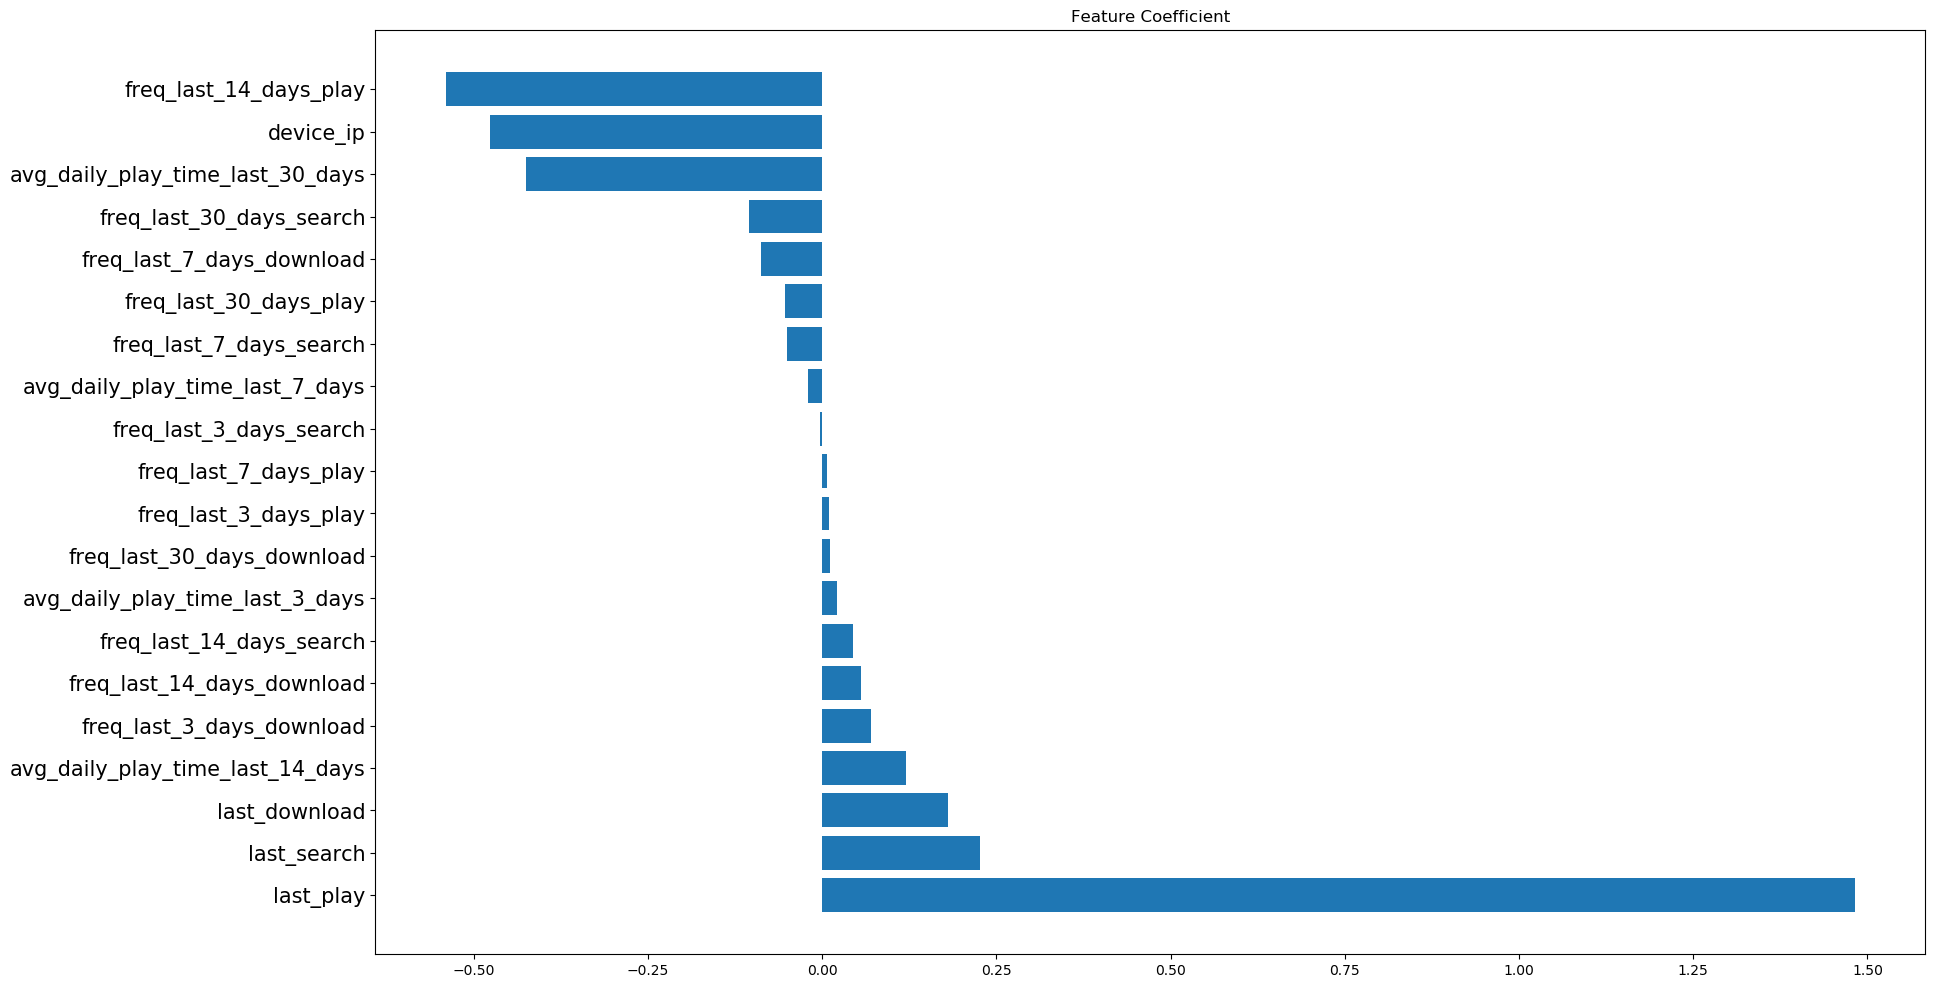

In [313]:
# same underlying, just play with different plot format
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(20,12))
ax.barh(np.arange(df_coef.shape[0]), df_coef['coefficient'], align='center')
ax.set_yticks(np.arange(df_coef.shape[0]))
ax.set_yticklabels(df_coef['features'], fontsize=15)

ax.set_title('Feature Coefficient')
plt.show()